In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rdm

# Lets do some data exploration

In [13]:

types_train = {'Sales': np.int32,
               'Store': np.int32,
               'DayOfWeek': np.int32,
               'Date': str,
               'Customers': np.int32,
               'Open': bool,
               'Promo': bool,
               'StateHoliday': str,
               'SchoolHoliday': bool}

df_train = pd.read_csv('./data/train.csv', dtype=types_train, parse_dates=['Date'])
df_train.dtypes

Store                     int32
DayOfWeek                 int32
Date             datetime64[ns]
Sales                     int32
Customers                 int32
Open                       bool
Promo                      bool
StateHoliday             object
SchoolHoliday              bool
dtype: object

Okay, we read the data correctly. Now lets get a feeling for the variables

In [12]:
df_train['Sales'].describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

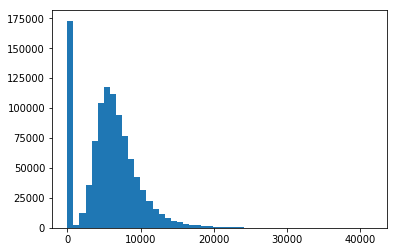

In [41]:
plt.hist(x=df_train['Sales'], bins=50);

Mean and deviation are affected by the days with 0 sales, but these are probably going to be predicted easily using the "Open" feature

In [6]:
df_clean_sales = df_train[df_train['Sales'] > 0]
df_clean_sales['Sales'].describe()

count    844338.000000
mean       6955.959134
std        3103.815515
min          46.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64

In [3]:
entries_per_store = df_train.groupby('Store').size()
print(entries_per_store.to_frame(name='Entries per store').describe())

       Entries per store
count        1115.000000
mean          912.295067
std            67.729422
min           758.000000
25%           942.000000
50%           942.000000
75%           942.000000
max           942.000000


There are indeed 1115 different stores, as descripted in the kaggle challenge. Normally there are 942 datapoints (=days) per store, some have a bit less but at least 758.

Lets do some sanity checks. This helps to see if we understand the data correctly or find errors in the data (unlikly for a kaggle challenge though)

In [4]:
print("Missing values? " + str(df_train.isnull().values.any()))
print('Percentage of days with 0 sales: {0:0.2f}'.format((df_train['Sales'] == 0).sum() / len(df_train['Sales'])))

Missing values? False
Percentage of days with 0 sales: 0.17


Seems reasonable, as 14% of the days are Sundays

In [32]:
print("Entries with 0 sales: " + 
      str((df_train['Sales'] == 0).sum()))
print("Entries with 0 sales and shop is closed: " + 
      str(len(df_train[(df_train['Sales'] == 0) & (~(df_train['Open']))])))
print("Entries with 0 sales although shop is open: " + 
      str(len(df_train[(df_train['Sales'] == 0) & (df_train['Open'])])))
print("Entries with sales > 0 although shop is closed: " + 
      str(len(df_train[(df_train['Sales'] > 0) & (~df_train['Open'])])))

Entries with 0 sales: 172871
Entries with 0 sales and shop is closed: 172817
Entries with 0 sales although shop is open: 54
Entries with sales > 0 although shop is closed: 0


No sales for an open shop seems odd, but 54 out of over 172817 isn't that much. Even if these points are errornous, they wont have a big impact.

In [11]:
print("Entries with store is open on a state holiday: " + 
      str(len(df_train[(df_train['StateHoliday'] != '0') & (df_train['Open'])])))
print("Entries with store is closed on a state holiday: " + 
      str(len(df_train[(df_train['StateHoliday'] != '0') & (~(df_train['Open']))])))

Entries with store is open on a state holiday: 910
Entries with store is closed on a state holiday: 30140


Now lets get a feeling for the other variables, and how big their impact on the sales are. Lets have a look at the correlation matrix

In [133]:
df_train['StateHoliday'] = pd.Categorical(df_train['StateHoliday']).codes
corr = df_train.corr(method='pearson')
corr.round(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,1.00,-0.00,0.01,0.02,-0.00,0.00,0.00,0.00
DayOfWeek,-0.00,1.00,-0.46,-0.39,-0.53,-0.39,-0.04,-0.21
Sales,0.01,-0.46,1.00,0.89,0.68,0.45,-0.23,0.09
Customers,0.02,-0.39,0.89,1.00,0.62,0.32,-0.20,0.07
Open,-0.00,-0.53,0.68,0.62,1.00,0.30,-0.34,0.09
Promo,0.00,-0.39,0.45,0.32,0.30,1.00,-0.02,0.07
StateHoliday,0.00,-0.04,-0.23,-0.20,-0.34,-0.02,1.00,0.20
SchoolHoliday,0.00,-0.21,0.09,0.07,0.09,0.07,0.20,1.00


count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64


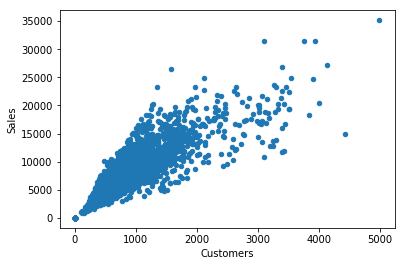

In [12]:
print(df_train['Customers'].describe())
subs_idx = rdm.sample(range(len(df_train)), 8000)
df_subset = pd.concat([df_train['Sales'], df_train['Customers']], axis=1).iloc[subs_idx]
df_subset.plot.scatter(x='Customers', y='Sales')

As expected, we can see a linear relationship between the amount of customers and the sales of a shop. With a correlation of nearly 90% to the target variable, this feature will help a lot to predict the sales.

In [58]:
df_daygrouped = df_train.groupby(['DayOfWeek']).sum()[['Sales', 'Open']]
df_daygrouped['Average Sale per Day'] = df_daygrouped['Sales']/df_daygrouped['Open']
df_daygrouped.round(2)

,Sales,Open,Average Sale per Day
DayOfWeek,,,
1,1130203012,137560.0,8216.07
2,1020411930,143961.0,7088.11
3,954962863,141936.0,6728.12
4,911177709,134644.0,6767.31
5,980555941,138640.0,7072.68
6,846317735,144058.0,5874.84
7,29551433,3593.0,8224.72


Opening on Sundays seems to pay off. No big difference between Tue, We, Thu, Fr

Let's train a really simple linear regression model, using only the (seemingly) most important feature, the amount of customers. This helps to get a feeling for the difficulty of predicting the sales and gives a baseline to compare other approaches with.


In [4]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error


#Cast to numpy for scikit-learn and only take the non-trivial datapoints
ar_data = df_train[df_train['Open'] == True].as_matrix(columns=['Sales', 'Customers'])

# Take 20% of randomly chosen datapoints for evaluation
n = len(ar_data)
np.random.shuffle(ar_data)
amnt_eval = int(np.round(0.2*n))
train_set = ar_data[amnt_eval:]
eval_set = ar_data[:amnt_eval]

# Train the model
linregr = linear_model.LinearRegression()
linregr.fit(X=train_set[:, 1].reshape(-1, 1), y=train_set[:, 0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Lets use the same evaluation function as in the original challenge: "Submissions are evaluated on the Root Mean Square Percentage Error (RMSPE) [..] Any day and store with 0 sales is ignored in scoring."

In [10]:
eval_y_pred = linregr.predict(eval_set[:, 1].reshape(-1, 1))
def rmspe(ar_pred, ar_truth):
    """
    Calculates the root mean square percentage error. Any entries with a truth value of 0 are ignored
    """
    nonzero_idx = np.nonzero(ar_truth)
    ar_pred = ar_pred[nonzero_idx]
    ar_truth = ar_truth[nonzero_idx]
    spe = np.power(np.divide(np.subtract(ar_pred, ar_truth), ar_truth), 2)
    return np.sqrt(np.average(spe))


print("RMSPE: {0:0.3f}".format(rmspe(eval_y_pred, eval_set[:, 0])))

RMSPE: 0.280


Not too bad regarding the fact we only used a single feature. Now lets find out if we could use some usefull information from the date, a feature we havent really looked at yet.

In [4]:
df_train['Date'].describe()

count                 1017209
unique                    942
top       2015-06-09 00:00:00
freq                     1115
first     2013-01-01 00:00:00
last      2015-07-31 00:00:00
Name: Date, dtype: object

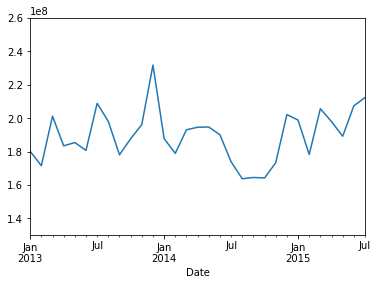

In [12]:
df_dateidx = df_train[['Sales', 'Date']].set_index('Date')
df_dateidx = df_dateidx.resample('M').sum()
#print(df_dateidx)
ax = df_dateidx['Sales'].plot()
ax.set_ylim([1.3 * 10**8, 2.6 * 10**8])
plt.show()

It is unlikely that we can craft a useful feature from the date. There isnt really a correlation between month and sales, e.g. Jul 2014 is the all-time low but Jul '13 and '15 have quite high sales. 

Good thing we have some more features regarding the stores, lets check out what we got there

In [151]:
types_store = {'Store': np.int32,
               'StoreType': str,
               'Assortment': str,
               'CompetitionDistance': str, # cant use int here, some cells are empty
               'CompetitionOpenSinceMonth': str,
               'CompetitionOpenSinceYear': str,
               'Promo2': bool,
               'Promo2SinceWeek': str,
               'Promo2SinceYear': str,
               'PromoInterval': str}
df_store = pd.read_csv('./data/store.csv',
                       dtype=types_store)
print('Amount of rows: ' + str(len(df_store)))    
print('Missing values? ' + str(df_store.isnull().values.any()))
df_store.dtypes

Amount of rows: 1115
Missing values? True


Store                         int32
StoreType                    object
Assortment                   object
CompetitionDistance          object
CompetitionOpenSinceMonth    object
CompetitionOpenSinceYear     object
Promo2                         bool
Promo2SinceWeek              object
Promo2SinceYear              object
PromoInterval                object
dtype: object

In [152]:
df_store.replace('', np.nan, inplace=True)
df_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

We need to do some data cleansing. Lets replace missing values at 'CompetitionDistance' with the median of that column. (Median is more robust to outliers than the mean) 

In [153]:
comp_dist_avg = df_store[~df_store['CompetitionDistance'].isnull()]['CompetitionDistance'].astype(np.float32).median()
print('Median distance to competitors: ' + str(comp_dist_avg))
comp_dist_avg = int(np.round(comp_dist_avg))
#df_store[df_store['CompetitionDistance'].isnull()]['CompetitionDistance'] = str(comp_dist_avg)
df_store['CompetitionDistance'].replace(np.nan, str(comp_dist_avg), inplace=True)
df_store['CompetitionDistance'] = df_store['CompetitionDistance'].astype(np.int32)
df_store.dtypes

Median distance to competitors: 2325.0


Store                         int32
StoreType                    object
Assortment                   object
CompetitionDistance           int32
CompetitionOpenSinceMonth    object
CompetitionOpenSinceYear     object
Promo2                         bool
Promo2SinceWeek              object
Promo2SinceYear              object
PromoInterval                object
dtype: object

Finding meanfull replacements for the columns "CompetitionOpenSinceMonth/Year' is more difficult. Lets have a closer look at these variables and if they actually influence the sales.

In [154]:
len(df_store[df_store['CompetitionOpenSinceYear'].isnull() & df_store['CompetitionOpenSinceYear'].isnull()])

354

We already knew that there are 354 null values in each column. So we either have both of them, or neither

In [155]:
df_comps = df_store[~df_store['CompetitionOpenSinceYear'].isnull()][['Store', 'CompetitionOpenSinceYear']]
df_comps = df_comps.astype(np.int32)
df_comps.describe()

,Store,CompetitionOpenSinceYear
count,761.000000,761.000000
mean,556.797635,2008.668857
std,322.605611,6.195983
min,1.000000,1900.000000
25%,281.000000,2006.000000
50%,570.000000,2010.000000
75%,831.000000,2013.000000
max,1112.000000,2015.000000


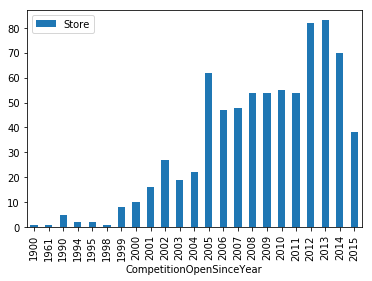

In [156]:
df_comps.groupby(['CompetitionOpenSinceYear']).count().plot.bar()

1900 is an outlier. It probably also doesnt make a difference if a competitor opened 20 or 30 years ago, so we can think about simplifying the data by unifying all pre-2000 datapoints. But lets see the relationship with the sales first.

In [157]:
df_comps = df_store[~df_store['CompetitionOpenSinceYear'].isnull()]
df_comps = df_comps.astype(dtype={'CompetitionOpenSinceYear': np.int32,
                       'CompetitionOpenSinceMonth': np.int32})
df_merge = pd.merge(df_train[['Store','Sales']], df_comps, how = 'inner', on = 'Store')
df_merge = df_merge.groupby('Store').agg(np.mean)
df_merge.corr(method='pearson')

,Sales,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
Sales,1.000000,-0.048979,-0.052453,0.018893,-0.176585
CompetitionDistance,-0.048979,1.000000,-0.059126,0.025124,-0.140708
CompetitionOpenSinceMonth,-0.052453,-0.059126,1.000000,-0.052250,-0.011485
CompetitionOpenSinceYear,0.018893,0.025124,-0.052250,1.000000,-0.076520
Promo2,-0.176585,-0.140708,-0.011485,-0.076520,1.000000


We aggregated over different dates using the mean, so sales contains the average sale per day for a certain store. The other values are simply the corresponding values for each store. We dont really see any high correlation values here. Suprisingly, Promo2 seems to have a negativ effect on the sales.

Lets just replace the missing values with 0 for now, one-hot encode the categorical features and get our complete dataset.

In [163]:
df_store.replace(np.nan, 0, inplace=True)
df_store.drop('PromoInterval', axis = 1)
df_store = df_store.astype(dtype={'CompetitionOpenSinceYear': np.int32,
                       'CompetitionOpenSinceMonth': np.int32})
df_merge = pd.merge(df_train, df_comps, how = 'inner', on = 'Store')
df_merge['Assortment'] = pd.Categorical(df_merge['Assortment']).codes
df_merge['StoreType'] = pd.Categorical(df_merge['StoreType']).codes
df_merge.corr(method='pearson')

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
Store,1.000000,0.000009,0.011029,0.031294,0.000923,-0.000037,0.000815,-0.000195,0.006064,-0.024612,-0.059835,-0.050746,-0.004592,0.007035
DayOfWeek,0.000009,1.000000,-0.465016,-0.401188,-0.530121,-0.392926,-0.044658,-0.208266,0.000053,-0.000056,-0.000021,0.000006,-0.000025,0.000178
Sales,0.011029,-0.465016,1.000000,0.906758,0.675621,0.452905,-0.228049,0.088388,0.003709,0.084118,-0.026918,-0.028257,0.012659,-0.092336
Customers,0.031294,-0.401188,0.906758,1.000000,0.629047,0.326866,-0.209601,0.076885,-0.117203,0.000228,-0.107785,-0.030954,0.008931,-0.163013
Open,0.000923,-0.530121,0.675621,0.629047,1.000000,0.296316,-0.340420,0.089089,-0.002863,0.002271,0.008024,0.001384,0.002771,-0.010123
Promo,-0.000037,-0.392926,0.452905,0.326866,0.296316,1.000000,-0.024885,0.072988,-0.000315,0.000315,0.000115,-0.000023,0.000152,-0.001043
StateHoliday,0.000815,-0.044658,-0.228049,-0.209601,-0.340420,-0.024885,1.000000,0.195997,0.001300,-0.001711,0.000084,0.000519,-0.002456,0.005413
SchoolHoliday,-0.000195,-0.208266,0.088388,0.076885,0.089089,0.072988,0.195997,1.000000,-0.002142,-0.003194,-0.004088,-0.000526,0.001520,-0.006850
StoreType,0.006064,0.000053,0.003709,-0.117203,-0.002863,-0.000315,0.001300,-0.002142,1.000000,0.290397,0.095552,0.026962,0.025143,0.053174
Assortment,-0.024612,-0.000056,0.084118,0.000228,0.002271,0.000315,-0.001711,-0.003194,0.290397,1.000000,0.187327,-0.000643,0.061422,-0.018637
